# Final Exam Solution

## FINM 37500 - 2023

### UChicago Financial Mathematics
### Madison Rusch

# Instructions

## Please note the following:

Points
* The exam is 150 points.
* You have 180 minutes to complete the exam.
* For every minute late you submit the exam, you will lose one point.
Final Exam

Submission
* You will upload your solution to the Final Exam assignment on Canvas, where you downloaded this.
* Your submission should be readable, (the graders can understand your answers,) and it should include all code used in your analysis in a file format that the code can be executed. (ie. .ipynb preferred, .pdf is unacceptable.)

Rules
* The exam is open-material, closed-communication.
* You do not need to cite material from the course github repo--you are welcome to use the code posted there without citation, (only for this exam.)

Advice
* If you find any question to be unclear, state your interpretation and proceed. We will only answer questions of interpretation if there is a typo, error, etc.
* The exam will be graded for partial credit.

## Data

**All data files are found in the class github repo, in the `data` folder.**

This exam makes use of the following data files:
* `exam_data_2023-05-05.xlsx`

This file has sheets for...
* curve data - discount factors and forward volatilities
* BDT tree of rates (continuously compounded, as usual)

If useful, the following code loads the two sheets:

In [86]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
from scipy.optimize import fsolve
from scipy.stats import norm

import sys
sys.path.insert(0, '../cmds')
from ficcvol import *
from binomial import *
from ratecurves import *

FILEIN = '../data/exam_data_2023-05-05.xlsx'
sheet_curves = 'rate curves'
sheet_tree = 'rate tree'

curves = pd.read_excel(FILEIN, sheet_name=sheet_curves).set_index('tenor')
ratetree = pd.read_excel(FILEIN, sheet_name=sheet_tree).set_index('state')
ratetree.columns.name = 'time'

## Scoring

| Problem | Points |
|---------|--------|
| 1       | 60     |
| 2       | 30     |
| 3       | 20     |
| 4       | 15     |
| 5       | 15     |
| 6       | 10     |

### Each numbered question is worth 5pts.

# 1. Short Answer

### No Data Needed

These problem does not require any data file. Rather, analyze the situation conceptually, based on the information below. 

A few questions may require simple arithmetic.

## 1.1

Consider a future on a 5-year treasury. If the exchange changes the treasury futures conversion factor to use a 3\% discount instead of 6\%, would you expect substantial changes to the...
* the futures price?
* the forward price of the underlying CTD treasury?

Explain.

We would expect a change in the futures price. The future price is calculated using the conversion factor to account for optionality in delivery, and so if it changes, we would expect the futures price to change as well. We would expect the forward to change as well, since conversion * futures price = forward price.

## 1.2

Explain how SABR allows for an extra "channel" of delta hedging.

SABR brings in another channel because of the change in implied volatility that occurs. The additional term consists of dC/dSigma * dSigma/dF, where C represents the call option and F represents the forward. We can bring in vanna with the dynamic volatility, and it allows for more accurate delta hedging (if we can get the slope of the vol path right).

## 1.3

Local volatility fits quoted volatilities exactly, whereas SABR does not.

What advantage does SABR have over local volatility? How does it relate to the fact above?

SABR gives us better out of sample prediction of volatility, and it is a fast, closed form solution which uses market quotes to allow us to get an entire volatility surface for delta hedging. Local volatility is not enough for accurate delta hedging since it doesn't get the time dynamics right.

## 1.4
Relative to three years ago, do you think BDT or Ho-Lee is better suited to today's interest rates?

Explain.

BDT is likely a better fit for today's interest rates, given how high they've gotten. Ho-Lee can yield negative interest rates, while it's more difficult to generate very low interest rates using Black-Derman-Toy. Three years ago, Ho-Lee was likely to be a better model, given the constantly low interest rates, but today BDT is better.

## 1.5
True or False: To value a caplet in Black's formula, we input the spot interest rate as the underlying.

Explain.

False. To value a caplet in Black's formula, we have to use the Caps and the flat volatility to generate prices for caps at many different expirations. Once we have the cap prices, we are able to bootstrap out the individual caplet prices by seeing how much value each individual caplet adds to the next expiration cap.

## 1.6
Should we expect a delta-hedged callable bond to underperform or overperform a delta-hedged vanilla bond? Explain.

Overperform. Because the bond is callable, we have many more points in time at which we may exercise the option and turn a profit/reduce our loss. This additional optionality makes it more likely that the callable bond will outperform the vanilla bond.

## 1.7
True or False: In a frictionless market, gross basis and net basis are nonzero before maturity, but they converge to zero for the CTD bond at maturity.

True. Because the conversion factor is applied at 6% regardless of market conditions, the future price at time 0 will never exactly equal the price of the bond when you are calculating gross basis (hence nonzero). Additionally, (assuming a frictionless market does not mean repo rate = 0), there will be some carry for each bond (either positive or negative). Then we don't expect net basis to equal zero either (gross basis - carry). At we approach expiration, we do also expect the two basises to converge. 


## 1.8
True or False: Bonds with higher coupons have larger "forward drops".

True. Bonds with higher coupons have higher carry, and holding the time to expiration equal, that means they will have a larger forward drop as the forward price adjusts accordingly for the earnings you make on the carry holding the bond.

## 1.9
True or False: We expect that high duration bonds are typically CTD.

True, assuming that the interest rate is above the 6% that the market makers use when calculating the conversion factor. Because the conversion factor harshly punishes longer duration bonds when the interest rate drops below that 6%, it is not necesarilly true that the high duration bond will be CTD in that case.

## 1.10

True or False: If forward volatility is decreasing over maturity then flat volatility is also decreasing over maturity.

True. The forward vols are calculated for individual caplets, which make up the caps where flat volatility is quoted. If each individual caplet has a lower volatility as it's time to maturity goes up, then the flat volatility for the caps in which it is a part will on average be lower as their time to maturity increases. 

## 1.11

True or False: From fed funds futures prices, we can extract the probability of interest rate movements for any meeting date.

True. If we are given the fed funds future prices, we can use them to determine the markets expectations of what the Fed will announce at their meetings, using a time weighted average.

## 1.12

How is Black's model useful---and necessary--- in fixed income derivatives, even if we choose to use a more complex, proprietary model.

Black's model allows us to use varying interest rates in our calculations of derivative pricing. Additionally, because bonds can't be modeled with a Geometric Brownian Motion - their volatility converges - we have to use Black's instead of Black-Scholes.

***

# 2. Bond Pricing

## 2.1
Use the BDT tree to price a bond.
* Time-to-maturity is 3 years
* Coupon rate is 1\%.

As usual, 
* coupons are paid semiannually.
* face value is $N=100$.

Display the tree of the bond's value, where each node is **as usual** the ex-coupon dirty price. 
* Thus, the value at node 0.5 is just after the coupon was paid.
* The value at node 0.25 includes accrued interest.

In [87]:
# ratetree

In [88]:
FACE = 100
T=3
compound = 4
cpn = .01
cpn_freq = 2

STRIKE = 100
CLEANCALL = True

dt = 1/compound
tsteps = int(T/dt)

wrapper_bond = lambda r: payoff_bond(r, dt, facevalue=FACE * (1+cpn/cpn_freq))
cftree = construct_bond_cftree(T, compound, cpn)
bondtree = bintree_pricing(payoff=wrapper_bond, ratetree=ratetree.iloc[:tsteps,:tsteps], cftree=cftree)
format_bintree(bondtree)

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75
state,,,,,,,,,,,,
0,92.85,92.15,91.51,90.38,89.76,88.59,88.04,87.35,87.68,88.10,90.28,93.76
1,,95.91,95.44,94.46,93.95,92.87,92.33,91.53,91.61,91.65,93.16,95.54
2,,,98.37,97.56,97.21,96.28,95.84,95.03,94.94,94.66,95.59,97.05
3,,,,99.70,99.50,98.74,98.45,97.72,97.60,97.13,97.59,98.24
4,,,,,100.96,100.33,100.18,99.56,99.50,99.01,99.25,99.33
5,,,,,,101.15,101.08,100.52,100.49,100.00,100.12,99.92
6,,,,,,,101.52,101.00,100.98,100.49,100.56,100.21
7,,,,,,,,101.23,101.23,100.73,100.77,100.35
8,,,,,,,,,101.35,100.85,100.87,100.42


We find that the price of the bond is $92.85.

## 2.2

Display the tree of the bond's **clean price** (still ex-coupon, as usual.)

In [89]:
accint = construct_accint(bondtree.columns.values, compound, cpn)
cleantree = np.maximum(bondtree.subtract(accint,axis=1),0)

format_bintree(cleantree)

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75
state,,,,,,,,,,,,
0,92.35,91.90,91.01,90.13,89.26,88.34,87.54,87.10,87.18,87.85,89.78,93.51
1,,95.66,94.94,94.21,93.45,92.62,91.83,91.28,91.11,91.40,92.66,95.29
2,,,97.87,97.31,96.71,96.03,95.34,94.78,94.44,94.41,95.09,96.80
3,,,,99.45,99.00,98.49,97.95,97.47,97.10,96.88,97.09,97.99
4,,,,,100.46,100.08,99.68,99.31,99.00,98.76,98.75,99.08
5,,,,,,100.90,100.58,100.27,99.99,99.75,99.62,99.67
6,,,,,,,101.02,100.75,100.48,100.24,100.06,99.96
7,,,,,,,,100.98,100.73,100.48,100.27,100.10
8,,,,,,,,,100.85,100.60,100.37,100.17


We find that the clean price of the bond is $92.35

## 2.3

Consider a European **put** option on the bond.
* Expiration of the option is 1 year.
* Strike is equal to face value, $100$.
* At exercise, the option holder receives the strike plus accrued interest.

Display the tree of the option price.

In [90]:
T = 1
tsteps = int(T/dt)+1

bondtreeT = bondtree.iloc[:tsteps,:tsteps]

payoff_put = lambda p: np.maximum(STRIKE-p,0)

puttree = bintree_pricing(payoff=payoff_put, ratetree=ratetree.iloc[:tsteps,:tsteps], undertree= bondtreeT)
format_bintree(puttree)

time,0.00,0.25,0.50,0.75,1.00
state,,,,,
0,3.16,4.47,6.10,8.01,10.24
1,,1.93,2.97,4.37,6.05
2,,,0.93,1.63,2.79
3,,,,0.25,0.50
4,,,,,0.00


## 2.4

Consider the same option, but this time **American**.

Display the tree of the option price.

In [91]:
payoff_put = lambda p: np.maximum(STRIKE-p,0)

puttree = bintree_pricing(payoff=payoff_put, ratetree=ratetree.iloc[:tsteps,:tsteps], undertree= bondtreeT, style='american')
format_bintree(puttree)

time,0.00,0.25,0.50,0.75,1.00
state,,,,,
0,7.15,7.85,8.49,9.62,10.24
1,,4.09,4.56,5.54,6.05
2,,,1.63,2.44,2.79
3,,,,0.30,0.50
4,,,,,0.00


## 2.5

Is there a node where the option is in-the-money, yet it is not optimal to exercise? 

Briefly explain, and if so, give an example.

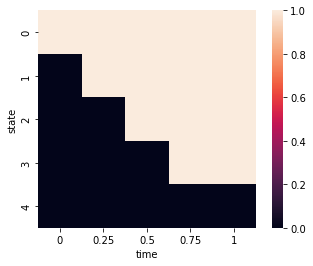

In [92]:
sns.heatmap(exercise_decisions(payoff_put,bondtreeT,puttree),square=True);

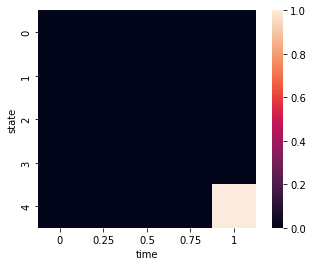

In [93]:
sns.heatmap(bondtreeT > STRIKE, square=True);

No. Looking at the trees and heatmaps above, there is never a moment in which we would want to hold when we are in-the-money. Though we saw examples of this in class, according to these calculations we should always exercise when our American option is in the money.

## 2.6 

Consider an **amortizing bond** with 
* maturity 2.5 years.
* coupon rate of 40\%.
* Notional of \$100.

Unlike a typical bond, it pays a coupon semiannually, but it does not ever pay the face value. In that sense, one could view the coupons as amortized payments of the face value.

Value the amortizing bond and display the valuation tree.

In [94]:

T=2.5
compound = 4
cpn = .4
cpn_freq = 2

STRIKE = 100
CLEANCALL = True

dt = 1/compound
tsteps = int(T/dt)

wrapper_bond = lambda r: payoff_bond(r, dt, facevalue=20)
cftree = construct_bond_cftree(T, compound, cpn)

bondtree = bintree_pricing(payoff=wrapper_bond, ratetree=ratetree.iloc[:tsteps,:tsteps], cftree=cftree)
format_bintree(bondtree)

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25
state,,,,,,,,,,
0,93.52,93.73,94.18,74.84,75.38,56.03,56.55,37.41,38.14,19.21
1,,95.69,95.97,76.41,76.75,57.19,57.53,38.13,38.65,19.42
2,,,97.41,77.68,77.88,58.15,58.34,38.73,39.07,19.60
3,,,,78.63,78.75,58.90,58.99,39.22,39.41,19.74
4,,,,,79.36,59.44,59.49,39.60,39.70,19.87
5,,,,,,59.72,59.74,39.80,39.85,19.93
6,,,,,,,59.87,39.90,39.92,19.97
7,,,,,,,,39.95,39.96,19.98
8,,,,,,,,,39.98,19.99


***

# 3 Floorlet

## 3.1 (5pts)

Consider a **floorlet** with
* Strike is $0.06$
* Notional $N=100$

As usual, the floorlet has a one-quarter lag between when the payoff is determined and when it is received.
* determined at $T=2$
* payoff at $T=2.25$.

Use the BDT tree of rates to value the floorlet. Display the valuation tree.

In [95]:
STRIKE = .06
N = 100
T = 2

tsteps = int(T/dt) + 1
compound = int(1/dt)

payoff = lambda r: N * dt * np.maximum(STRIKE-r,0)
format_bintree(bintree_pricing(payoff=payoff, ratetree=ratetree.iloc[:tsteps,:tsteps], undertree=ratetree.iloc[:tsteps,:tsteps]))

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00
state,,,,,,,,,
0,0.80,0.66,0.50,0.33,0.18,0.06,0.00,0.00,0.00
1,,0.96,0.83,0.68,0.50,0.30,0.12,0.00,0.00
2,,,1.11,1.01,0.87,0.70,0.49,0.25,0.00
3,,,,1.24,1.16,1.06,0.92,0.74,0.51
4,,,,,1.33,1.28,1.21,1.11,0.99
5,,,,,,1.39,1.35,1.31,1.25
6,,,,,,,1.42,1.40,1.37
7,,,,,,,,1.45,1.43
8,,,,,,,,,1.46


## 3.2 (5pts)

Regardless of your price above, assume the market is quoting the floorlet at a price of \$0.80.

Use Black's formula to calculate the implied volatility of this floorlet, supposing the underlying is currently 3.5\%.

In [111]:
def black_derman_toy(discount_factor, T, strike, underlying, sigma):
    d_1 = (math.log(underlying/strike) + (sigma**2 * T / 2)) / (sigma * math.sqrt(T))
    d_2 = d_1 - (sigma * math.sqrt(T))
    value = discount_factor * (strike * norm.cdf(-d_2) - underlying * norm.cdf(-d_1))
    return value

def black_derman_toy_get_forward_vol(sigma, price, discount_factor, T, strike, underlying):
    return black_derman_toy(discount_factor, T, strike, underlying, sigma) - price

caplet_price = 0.8 * (4/100)
discount_factor = math.exp(-0.035 * 2)
forward = 0.035
print(discount_factor)
# fwd_prices = ((px + int_already_acc)  * (1+repo * days_next_cpn/360) - FACE*cpn/2) * (1+repo * days_past_cpn/360) - int_postcpn_acc

result = fsolve(black_derman_toy_get_forward_vol, .5, args=(caplet_price, discount_factor, T, STRIKE, forward))
# result
print("The implied vol is: ", round(result[0], 2))

0.9323938199059483
The implied vol is:  4.4


NOTE: I am aware the above is suspicious, but I did not calculate the forward correctly I believe.

## 3.3 (5pts)

Based on your answers to 3.1 and 3.2, is the OAS positive or negative? Explain.

In this case my OAS is actually 0. OAS is the amount you have to shift your model prediction to make it match the market, and since my model predicted a price of 0.80, and the market was also quoting 0.80, then the OAS in this instance was 0. 

## 3.4 (5pts)

Consider a floorlet which pays immediately upon the payoff being determined rather than having the one-quarter lag.

Price this alternate floorlet and display the valuation tree.

In [97]:
STRIKE = .06
N = 100
T = 2.25

tsteps = int(T/dt) + 1
compound = int(1/dt)

payoff = lambda r: N * dt * np.maximum(STRIKE-r,0)
format_bintree(bintree_pricing(payoff=payoff, ratetree=ratetree.iloc[:tsteps,:tsteps], undertree=ratetree.iloc[:tsteps,:tsteps]))

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25
state,,,,,,,,,,
0,0.81,0.67,0.51,0.36,0.21,0.09,0.02,0.00,0.00,0.00
1,,0.97,0.84,0.69,0.51,0.33,0.17,0.04,0.00,0.00
2,,,1.11,1.01,0.87,0.71,0.51,0.29,0.09,0.00
3,,,,1.24,1.16,1.06,0.92,0.74,0.50,0.18
4,,,,,1.32,1.27,1.20,1.11,0.99,0.83
5,,,,,,1.38,1.35,1.30,1.24,1.16
6,,,,,,,1.42,1.40,1.37,1.33
7,,,,,,,,1.45,1.43,1.41
8,,,,,,,,,1.46,1.45


***

# 4. Swaps

## 4.1 

Consider a **paying-fixed** swap which resets (and make payments) **quarterly**.
* Maturity is $T=3$
* Notional is $N=100$.
* Swap rate is 3.53\%.
* The floating rate is the quarterly compounded interest rate.

(Recall that paying-fixed means you pay the swap rate and receive the floating rate.)

Display the cashflow tree.

In [98]:
STRIKE = .0353
N = 100
T=3
dt = 0.25

tsteps = int(T/dt) + 1
compound = int(1/dt)

payoff = lambda r: N * dt * (r-STRIKE)
refratetree = compound * (np.exp(ratetree / compound)-1)
cftree = payoff(refratetree.iloc[:tsteps,:tsteps])
format_bintree(cftree)

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00
state,,,,,,,,,,,,,
0,0.39,0.55,0.66,0.75,0.75,0.92,1.28,1.74,2.19,3.22,4.51,6.31,8.44
1,,0.16,0.24,0.31,0.31,0.43,0.69,1.02,1.35,2.09,3.02,4.31,5.83
2,,,-0.11,-0.06,-0.06,0.02,0.20,0.43,0.65,1.16,1.79,2.67,3.70
3,,,,-0.35,-0.35,-0.30,-0.18,-0.03,0.11,0.44,0.85,1.42,2.08
4,,,,,-0.61,-0.58,-0.52,-0.45,-0.37,-0.21,0.00,0.29,0.63
5,,,,,,-0.73,-0.70,-0.67,-0.63,-0.55,-0.44,-0.30,-0.14
6,,,,,,,-0.79,-0.77,-0.76,-0.71,-0.66,-0.59,-0.51
7,,,,,,,,-0.83,-0.82,-0.80,-0.77,-0.73,-0.69
8,,,,,,,,,-0.85,-0.84,-0.82,-0.80,-0.78


## 4.2

Display the value tree.

In [99]:
swaptree = bintree_pricing(payoff=payoff, ratetree=ratetree.iloc[:tsteps,:tsteps], undertree= refratetree.iloc[:tsteps,:tsteps], cftree=cftree, timing='deferred')
format_bintree(swaptree)

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00
state,,,,,,,,,,,,,
0,-0.19,1.55,3.28,5.06,6.89,8.85,10.77,12.42,13.63,14.35,13.97,12.04,7.72
1,,-2.71,-1.24,0.29,1.89,3.64,5.42,7.04,8.37,9.35,9.47,8.38,5.46
2,,,-4.56,-3.27,-1.92,-0.43,1.11,2.59,3.93,5.06,5.61,5.26,3.54
3,,,,-5.69,-4.54,-3.31,-2.02,-0.74,0.47,1.60,2.41,2.67,2.02
4,,,,,-6.20,-5.13,-4.04,-2.96,-1.91,-0.89,-0.04,0.52,0.62
5,,,,,,-6.07,-5.09,-4.11,-3.14,-2.20,-1.34,-0.62,-0.13
6,,,,,,,-5.61,-4.68,-3.76,-2.85,-1.98,-1.18,-0.51
7,,,,,,,,-4.96,-4.06,-3.17,-2.30,-1.46,-0.69
8,,,,,,,,,-4.22,-3.33,-2.45,-1.60,-0.78


## 4.3

Consider a **european** swaption, (option to enter into the paying-fixed swap).
* expiration is $T=1$
* there is no strike at exercise.
    - could think of this as a strike of 0
    - but often referred to as a strike of 3.53\%, the fixed rate on the underlying swap
    
Display the swaption valuation tree.

In [100]:
T = 1
tsteps = int(T/dt)+1

payoff = lambda v: np.maximum(v,0)

swaptreeT = swaptree.iloc[:tsteps,:tsteps]

swaption_tree = bintree_pricing(payoff=payoff,  ratetree=ratetree.iloc[:tsteps,:tsteps], undertree= swaptreeT)
format_bintree(swaption_tree)

time,0.00,0.25,0.50,0.75,1.00
state,,,,,
0,0.86,1.50,2.59,4.32,6.89
1,,0.23,0.46,0.93,1.89
2,,,0.00,0.00,0.00
3,,,,0.00,0.00
4,,,,,0.00


***

# 5. Treasury Futures

## 5.1

Consider a bond with
* Market (clean) price of 97.50
* Futures conversion ratio of 0.95

It has
* Coupon rate of 1\% 
* face value of 100.

As for the coupon timing,
* The bond paid a coupon 38 days ago.
* It will pay another coupon in 144 days.
* The repo rate over the next 90 days is (annualized in the usual way) 5\%.

Calculate the forward price of the bond for delivery in 90 days. 

In [101]:
from datetime import datetime
from datetime import date

date_issue = date(2023,2,28)
date_coupon = date(2023,8,31)
date_now = date(2023,4,18)
date_fwd = date(2023,8,1)

days_cpn = 144
days_accint0 = 0
days_accint1 = 90
days_fwd = 90

spot = 97.5
repo = .05
cpn = .01
face = 100

accint0 = cpn*face/2 * (days_accint0 / days_cpn)
accint1 = cpn*face/2 * (days_accint1 / days_cpn)

fwd = (spot + accint0) * (1+repo * days_fwd/360) - accint1

fwd_spot = pd.DataFrame({'prices':[spot, fwd], 'carry':face*np.array([cpn,repo])}, index=['spot','forward'])
fwd_spot.loc['difference'] = [spot-fwd, (accint1-accint0) - face*(repo * days_fwd/360)]
fwd_spot.style.format('{:.4f}')

,prices,carry
spot,97.5000,1.0000
forward,98.4062,5.0000
difference,-0.9062,-0.9375


Using the table above, we see the Forward price for this (assuming it issued today) is $98.41. This intuitively makes sense as we expect the forward price to be higher when coupon > repo rate.

## 5.2

Calculate the gross and net basis of the bond.


In [102]:
px = 97.5
future = 103
conversion = .95

gross_basis = (px - future * conversion)

print(f"We find the gross basis (in dollars) to be: {round(gross_basis, 2)}")

We find the gross basis (in dollars) to be: -0.35


In [103]:
days_cpn_period = 38 + 144
days_already_accrued = 38

int_already_acc = cpn*FACE/2 * (days_already_accrued / days_cpn_period)
pxdirty = px + int_already_acc

carry = ((FACE * cpn - repo * pxdirty) * days_fwd / 360)
net_basis = gross_basis - carry
print(f"We find the net basis (in dollars) to be: {round(net_basis, 2)}")

We find the net basis (in dollars) to be: 0.62


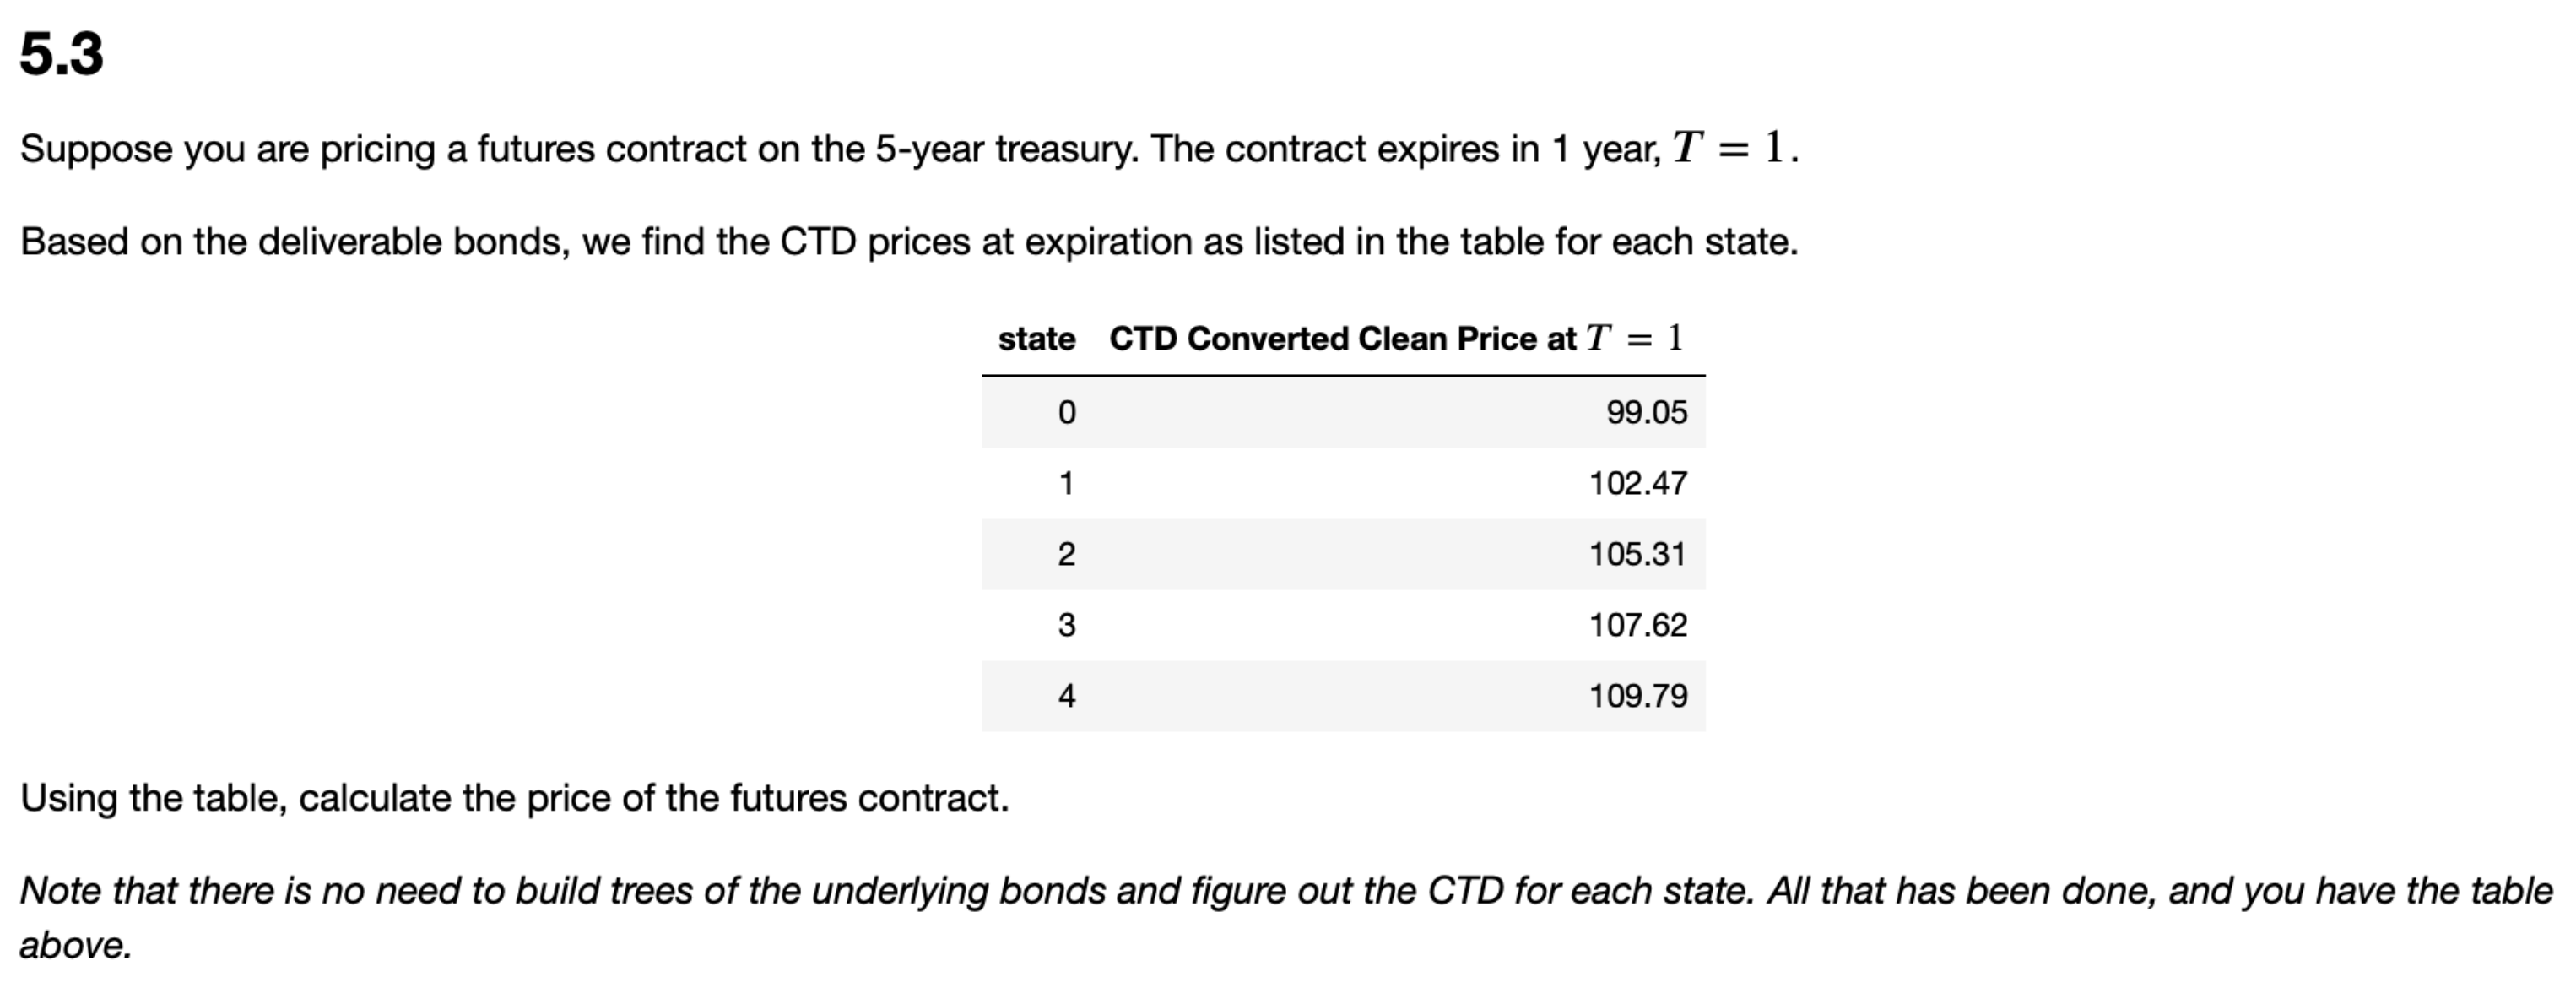

In [104]:
terminalvals = pd.DataFrame(data = [99.05, 102.47, 105.31, 107.62, 109.79], index=ratetree.index[0:5])

payoff_fun = lambda r: (terminalvals / conversion).values

ratetree_fwd_measure = ratetree.copy().loc[:,:1].dropna(how='all')
ratetree_fwd_measure *= 0

ratetree_fwd_measure

futtree = bintree_pricing(payoff=payoff_fun,ratetree=ratetree_fwd_measure)
format_bintree(futtree)

time,0.00,0.25,0.50,0.75,1.00
state,,,,,
0,110.60,109.21,107.71,106.06,104.26
1,,111.98,110.71,109.36,107.86
2,,,113.25,112.07,110.85
3,,,,114.43,113.28
4,,,,,115.57


We find the price of the futures contract is $110.60

***

# 6. Fitting the BDT Tree

Fit a BDT Tree. We will not use it for any other questions on the exam. 


## 6.1
Use the discount rates provided in the data file.

Instead of using the forward volatilities, use a constant $\sigma=0.50$ at every step.

Report the estimated thetas.


In [105]:
# curves
quotes = curves['discounts']*100
sigmas = 0.5
theta, ratetree = estimate_theta(sigmas,quotes)
format_bintree(theta.to_frame().T, style='{:.2%}')

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00
theta,,-21.68%,-46.23%,-53.73%,-82.74%,-52.01%,-22.63%,-24.76%,-44.13%,1.63%,-7.46%,-6.54%,-20.62%



## 6.2
Regardless of your previous answer, suppose your estimated thetas are all equal to 0.5.

Display the interest-rate tree.

In [106]:
def rates_to_BDTstates(ratetree):
    ztree = np.log(100*ratetree)
    return ztree

def BDTstates_to_rates(ztree):
    ratetree = np.exp(ztree)/100
    return ratetree

def incrementBDTtree(ratetree, theta, sigma, dt=None):
    if dt is None:
        dt = ratetree.columns[1] - ratetree.columns[0]

    tstep = len(ratetree.columns)-1
    
    ztree = rates_to_BDTstates(ratetree)
    ztree.iloc[:,-1] = ztree.iloc[:,-2] + theta * dt + sigma * np.sqrt(dt)
    ztree.iloc[-1,-1] = ztree.iloc[-2,-2] + theta * dt - sigma * np.sqrt(dt)
    
    newtree = BDTstates_to_rates(ztree)
    return newtree

def estimate_theta(sigmas,quotes_zeros,dt=None,T=None):
    if dt is None:
        dt = quotes_zeros.index[1] - quotes_zeros.index[0]

    if T is None:
        T = quotes_zeros.index[-2]

    ratetree = construct_rate_tree(dt,T)
    theta = pd.Series(dtype=float, index=ratetree.columns, name='theta')
    dt = ratetree.columns[1] - ratetree.columns[0]
    
    if type(sigmas) is float:
        sigmas = pd.Series(sigmas,index=theta.index)

    for tsteps, t in enumerate(quotes_zeros.index):
        if tsteps==0:
            ratetree.loc[0,0] = -np.log(quotes_zeros.iloc[tsteps]/100)/dt
        else:
            subtree = ratetree.iloc[:tsteps+1,:tsteps+1]
            theta.iloc[tsteps] = 0.5
            ratetree.iloc[:,tsteps] = incrementBDTtree(subtree, theta.iloc[tsteps], sigmas.iloc[tsteps]).iloc[:,tsteps]
            
            
    return theta, ratetree


theta, ratetree = estimate_theta(sigmas,quotes)
format_bintree(ratetree,style='{:.2%}')

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00
state,,,,,,,,,,,,,
0,5.04%,7.33%,10.67%,15.52%,22.59%,32.86%,47.82%,69.57%,101.23%,147.29%,214.31%,311.81%,453.68%
1,,4.45%,6.47%,9.42%,13.70%,19.93%,29.00%,42.20%,61.40%,89.34%,129.98%,189.12%,275.17%
2,,,3.93%,5.71%,8.31%,12.09%,17.59%,25.60%,37.24%,54.18%,78.84%,114.71%,166.90%
3,,,,3.46%,5.04%,7.33%,10.67%,15.52%,22.59%,32.86%,47.82%,69.57%,101.23%
4,,,,,3.06%,4.45%,6.47%,9.42%,13.70%,19.93%,29.00%,42.20%,61.40%
5,,,,,,2.70%,3.93%,5.71%,8.31%,12.09%,17.59%,25.60%,37.24%
6,,,,,,,2.38%,3.46%,5.04%,7.33%,10.67%,15.52%,22.59%
7,,,,,,,,2.10%,3.06%,4.45%,6.47%,9.42%,13.70%
8,,,,,,,,,1.85%,2.70%,3.93%,5.71%,8.31%


***